# Multiclass segmentation with the Lovász-Softmax
## Tensorflow version, see PyTorch version for more details & use in training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf

In [5]:
import lovasz_losses_tf as L

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# add parent path to pythonpath to import demo_utils
import sys
sys.path.append('../demo_helpers')
from demo_utils import pil_grid, dummy_triangles, printoptions
from demo_utils_tf import define_scope

In [8]:
# add pytorch folder to path for comparison
sys.path.append('../pytorch')
import lovasz_losses as L_pytorch

## Batch of 2 random images with classes [0, 1, 2] and void (255)

### Labels

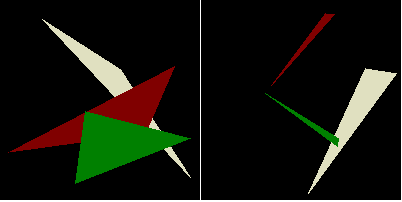

In [9]:
np.random.seed(18)
IGNORE = 255
C = 3
B = 2
H = 200
labels_ = [dummy_triangles(H, [0, 255, 1, 2]) for b in range(B)]
labels = np.stack(map(np.array, labels_)).astype(np.uint8)
pil_grid(labels_, 5, margin=1)

### Features

In [10]:
np.random.seed(57)
B, H, W = labels.shape
labels_ = labels.copy()
labels_[labels_ == 255] = np.random.randint(C, size=labels_.shape)[labels_ == 255] # random feats for void
labels_1hot = np.zeros((B, C, H, W))
for (b, h, w), c in np.ndenumerate(labels_):
    labels_1hot[b, c, h, w] = 1

In [11]:
feats = labels_1hot.copy()
feats += np.random.normal(0, 2, size=feats.shape)

## Model

### PyTorch reference

In [12]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn
import lovasz_losses as L_pytorch

class ModelPytorch(nn.Module):
    def __init__(self):
        super(ModelPytorch, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, padding=1)
        
    def forward(self, x):
        return x + self.conv(x)

m_torch = ModelPytorch().cuda()
out = m_torch(Variable(torch.from_numpy(feats.astype(np.float32)).cuda()))
out = F.softmax(out)
loss_torch = L_pytorch.lovasz_softmax(out, torch.from_numpy(labels).cuda(),
                                      only_present=True, ignore=IGNORE, per_image=False)

In [13]:
with printoptions(precision=4, suppress=True):
    print(out[0, 0, :10, :10].data.cpu().numpy())

[[0.4722 0.222  0.6203 0.0397 0.9062 0.0933 0.099  0.8619 0.1315 0.6689]
 [0.4159 0.8189 0.7507 0.1037 0.2848 0.0378 0.4918 0.9708 0.3758 0.2633]
 [0.9627 0.0827 0.0006 0.42   0.1284 0.9136 0.9665 0.0449 0.3112 0.9473]
 [0.1471 0.7988 0.4883 0.6556 0.0008 0.9395 0.0004 0.0186 0.9596 0.9116]
 [0.2837 0.2636 0.085  0.5021 0.9866 0.9922 0.0976 0.1139 0.059  0.2679]
 [0.0837 0.0062 0.9505 0.8732 0.6125 0.2149 0.0204 0.0632 0.8465 0.9902]
 [0.0984 0.1766 0.9628 0.3444 0.0366 0.9338 0.3781 0.6246 0.4485 0.6473]
 [0.1511 0.8784 0.0405 0.0606 0.7757 0.9289 0.2071 0.0471 0.9766 0.5254]
 [0.9081 0.8976 0.0018 0.9706 0.9061 0.5546 0.2858 0.8041 0.9759 0.3486]
 [0.0928 0.4608 0.237  0.9437 0.7446 0.2623 0.1667 0.0097 0.206  0.9204]]


In [15]:
loss_torch.data.cpu().item()

0.7759113311767578

#### small gradient check

In [16]:
loss_torch.backward()

In [17]:
m_torch.conv.bias.grad.data.cpu().numpy()

array([-0.04676518,  0.02505459,  0.02171059], dtype=float32)

### Tensorflow model definition

In [18]:
class Model:
    '''
    Simple linear model
    '''
    
    def __init__(self, feats):
        self.feats = feats
        self.scores
        self.predict

    @define_scope
    def scores(self):
        x = self.feats
        # replicate pytorch initialization
        init_weight = m_torch.conv.weight.data.cpu().numpy().transpose((2, 3, 1, 0))
        init_bias = m_torch.conv.bias.data.cpu().numpy()
        out = tf.nn.conv2d(x, tf.Variable(init_weight), strides=[1, 1, 1, 1], padding="SAME")
        out = tf.nn.bias_add(out, tf.Variable(init_bias))
        return x + out
    
    @define_scope
    def probas(self):
        return tf.nn.softmax(self.scores, 3)
    
    @define_scope
    def predict(self):
        return tf.argmax(self.scores, 3)

In [19]:
sess = tf.InteractiveSession()

In [20]:
labels_tf = tf.placeholder(np.int64, shape=(None, H, W), name='labels')
feats_tf = tf.placeholder(np.float32, shape=(None, H, W, C), name='features')

feed_dict = {labels_tf: labels, 
             feats_tf: feats.transpose(0, 2, 3, 1)}

In [21]:
m = Model(feats_tf)

In [22]:
sess.run(tf.global_variables_initializer())

In [24]:
loss = L.lovasz_softmax(m.probas, labels_tf,
                        ignore=IGNORE, per_image=False)

In [25]:
m.probas.eval(feed_dict).shape

(2, 200, 200, 3)

In [26]:
with printoptions(precision=4, suppress=True):
    print(m.probas.eval(feed_dict)[0, :10, :10, 0])

[[0.4722 0.222  0.6203 0.0397 0.9062 0.0933 0.099  0.8619 0.1315 0.6689]
 [0.4159 0.8189 0.7507 0.1037 0.2848 0.0378 0.4918 0.9708 0.3758 0.2633]
 [0.9627 0.0827 0.0006 0.42   0.1284 0.9136 0.9665 0.0449 0.3112 0.9473]
 [0.1471 0.7988 0.4883 0.6556 0.0008 0.9395 0.0004 0.0186 0.9596 0.9116]
 [0.2837 0.2636 0.085  0.5021 0.9866 0.9922 0.0976 0.1139 0.059  0.2679]
 [0.0837 0.0062 0.9505 0.8732 0.6125 0.2149 0.0204 0.0632 0.8465 0.9902]
 [0.0984 0.1766 0.9628 0.3444 0.0366 0.9338 0.3781 0.6246 0.4485 0.6473]
 [0.1511 0.8784 0.0405 0.0606 0.7757 0.9289 0.2071 0.0471 0.9766 0.5254]
 [0.9081 0.8976 0.0018 0.9706 0.9061 0.5546 0.2858 0.8041 0.9759 0.3486]
 [0.0928 0.4608 0.237  0.9437 0.7446 0.2623 0.1667 0.0097 0.206  0.9204]]


In [27]:
loss.eval(feed_dict)

0.7759113

#### Gradient w.r.t. bias

In [28]:
tf.trainable_variables()

[<tf.Variable 'scores/Variable:0' shape=(3, 3, 3, 3) dtype=float32_ref>,
 <tf.Variable 'scores/Variable_1:0' shape=(3,) dtype=float32_ref>]

In [29]:
tf.gradients(loss, tf.trainable_variables()[1])[0].eval(feed_dict)

array([-0.04676518,  0.02505459,  0.02171059], dtype=float32)